In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

import os
#path_wd='./drive/MyDrive/MineriaIII'
#os.chdir(path_wd)

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import cv2
import re
import scipy
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,ParameterGrid, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
sns.set_theme()

path_models='models/'
path_pred='predictions/'
path_data='Sentinel2LULC_354/'
path_test='Test 2/'
ext_sub = '.csv'

print(np.__version__)

1.20.3


In [83]:
label_groups = {1:1, 2:2, 3:3, 4:4,5:4, 6:5,7:5,8:5,9:5,10:5,11:5,12:5,13:5,14:5,15:5,16:5,17:5, 
                18:6,19:6,20:6, 21:7,22:7, 23:8, 24:9,25:9,26:9,27:9,28:9, 29:10}
subgroup = 9

In [84]:
data = []
labels = []

for d in os.listdir(path_data):
    lab = int(re.search('\d{1,2}', d).group())
    if label_groups.get(lab) == subgroup:
        for f in os.listdir(path_data + d):
            try:
                img = cv2.imread(path_data + d + '/' + f)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                data.append(img)
                labels.append(lab)
            except:
                print("Cannot read file: " + d + '/' + f)

data = np.array(data)
labels = np.array(labels)

In [85]:
train, val = train_test_split(np.arange(len(labels)), test_size=0.2, stratify=labels)
train_data = data[train]
train_labels = labels[train]
val_data = data[val]
val_labels = labels[val]

In [88]:
test_data = []
test_labels = []

for f in os.listdir(path_test):
    lab = int(re.search('^(\d{1,2})_', f).group(1))
    if label_groups.get(lab) == subgroup:
        try:
            img = cv2.imread(path_test + f)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            test_data.append(img)
            test_labels.append(lab)
        except:
            print("Cannot read file: " + f)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [89]:
train_data = train_data.reshape(train_data.shape[0], -1)/255.0
val_data = val_data.reshape(val_data.shape[0], -1)/255.0
test_data = test_data.reshape(test_data.shape[0], -1)/255.0

nclasses = len(np.unique(train_labels))
factor_labels = np.min(train_labels)
targets = np.unique(np.sort(train_labels))

In [75]:
#pca = PCA(n_components=100).fit(train_data)
#train_pca = pca.transform(train_data)
#val_pca = pca.transform(val_data)

In [90]:
umap = UMAP(n_neighbors=15, n_components=100, metric='manhattan').fit(train_data, y=train_labels)

In [91]:
#neigh = [5, 10, 15, 20]
#for k in neigh:
tuned_parameters = [{'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1), 'kernel': ['rbf']}]
svm = RandomizedSearchCV(SVC(), tuned_parameters)
train_umap = umap.transform(train_data)
svm.fit(train_umap[:,0:19], train_labels)

RandomizedSearchCV(estimator=SVC(),
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000297E9ACAE08>,
                                         'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000297EECF4808>,
                                         'kernel': ['rbf']}])

In [92]:
val_umap = umap.transform(val_data)
val_pred = svm.predict(val_umap[:,0:19])
print(classification_report(val_labels, val_pred, target_names=targets.astype(str)))

              precision    recall  f1-score   support

          24       0.48      0.35      0.41        71
          25       0.40      0.32      0.36        71
          26       0.48      0.67      0.56        70
          27       0.35      0.39      0.37        71
          28       0.49      0.46      0.47        71

    accuracy                           0.44       354
   macro avg       0.44      0.44      0.43       354
weighted avg       0.44      0.44      0.43       354



In [51]:
test_umap = umap.transform(test_data)
test_pred = svm.predict(test_umap[:,0:19])
print(classification_report(test_labels, test_pred, target_names=targets.astype(str)))

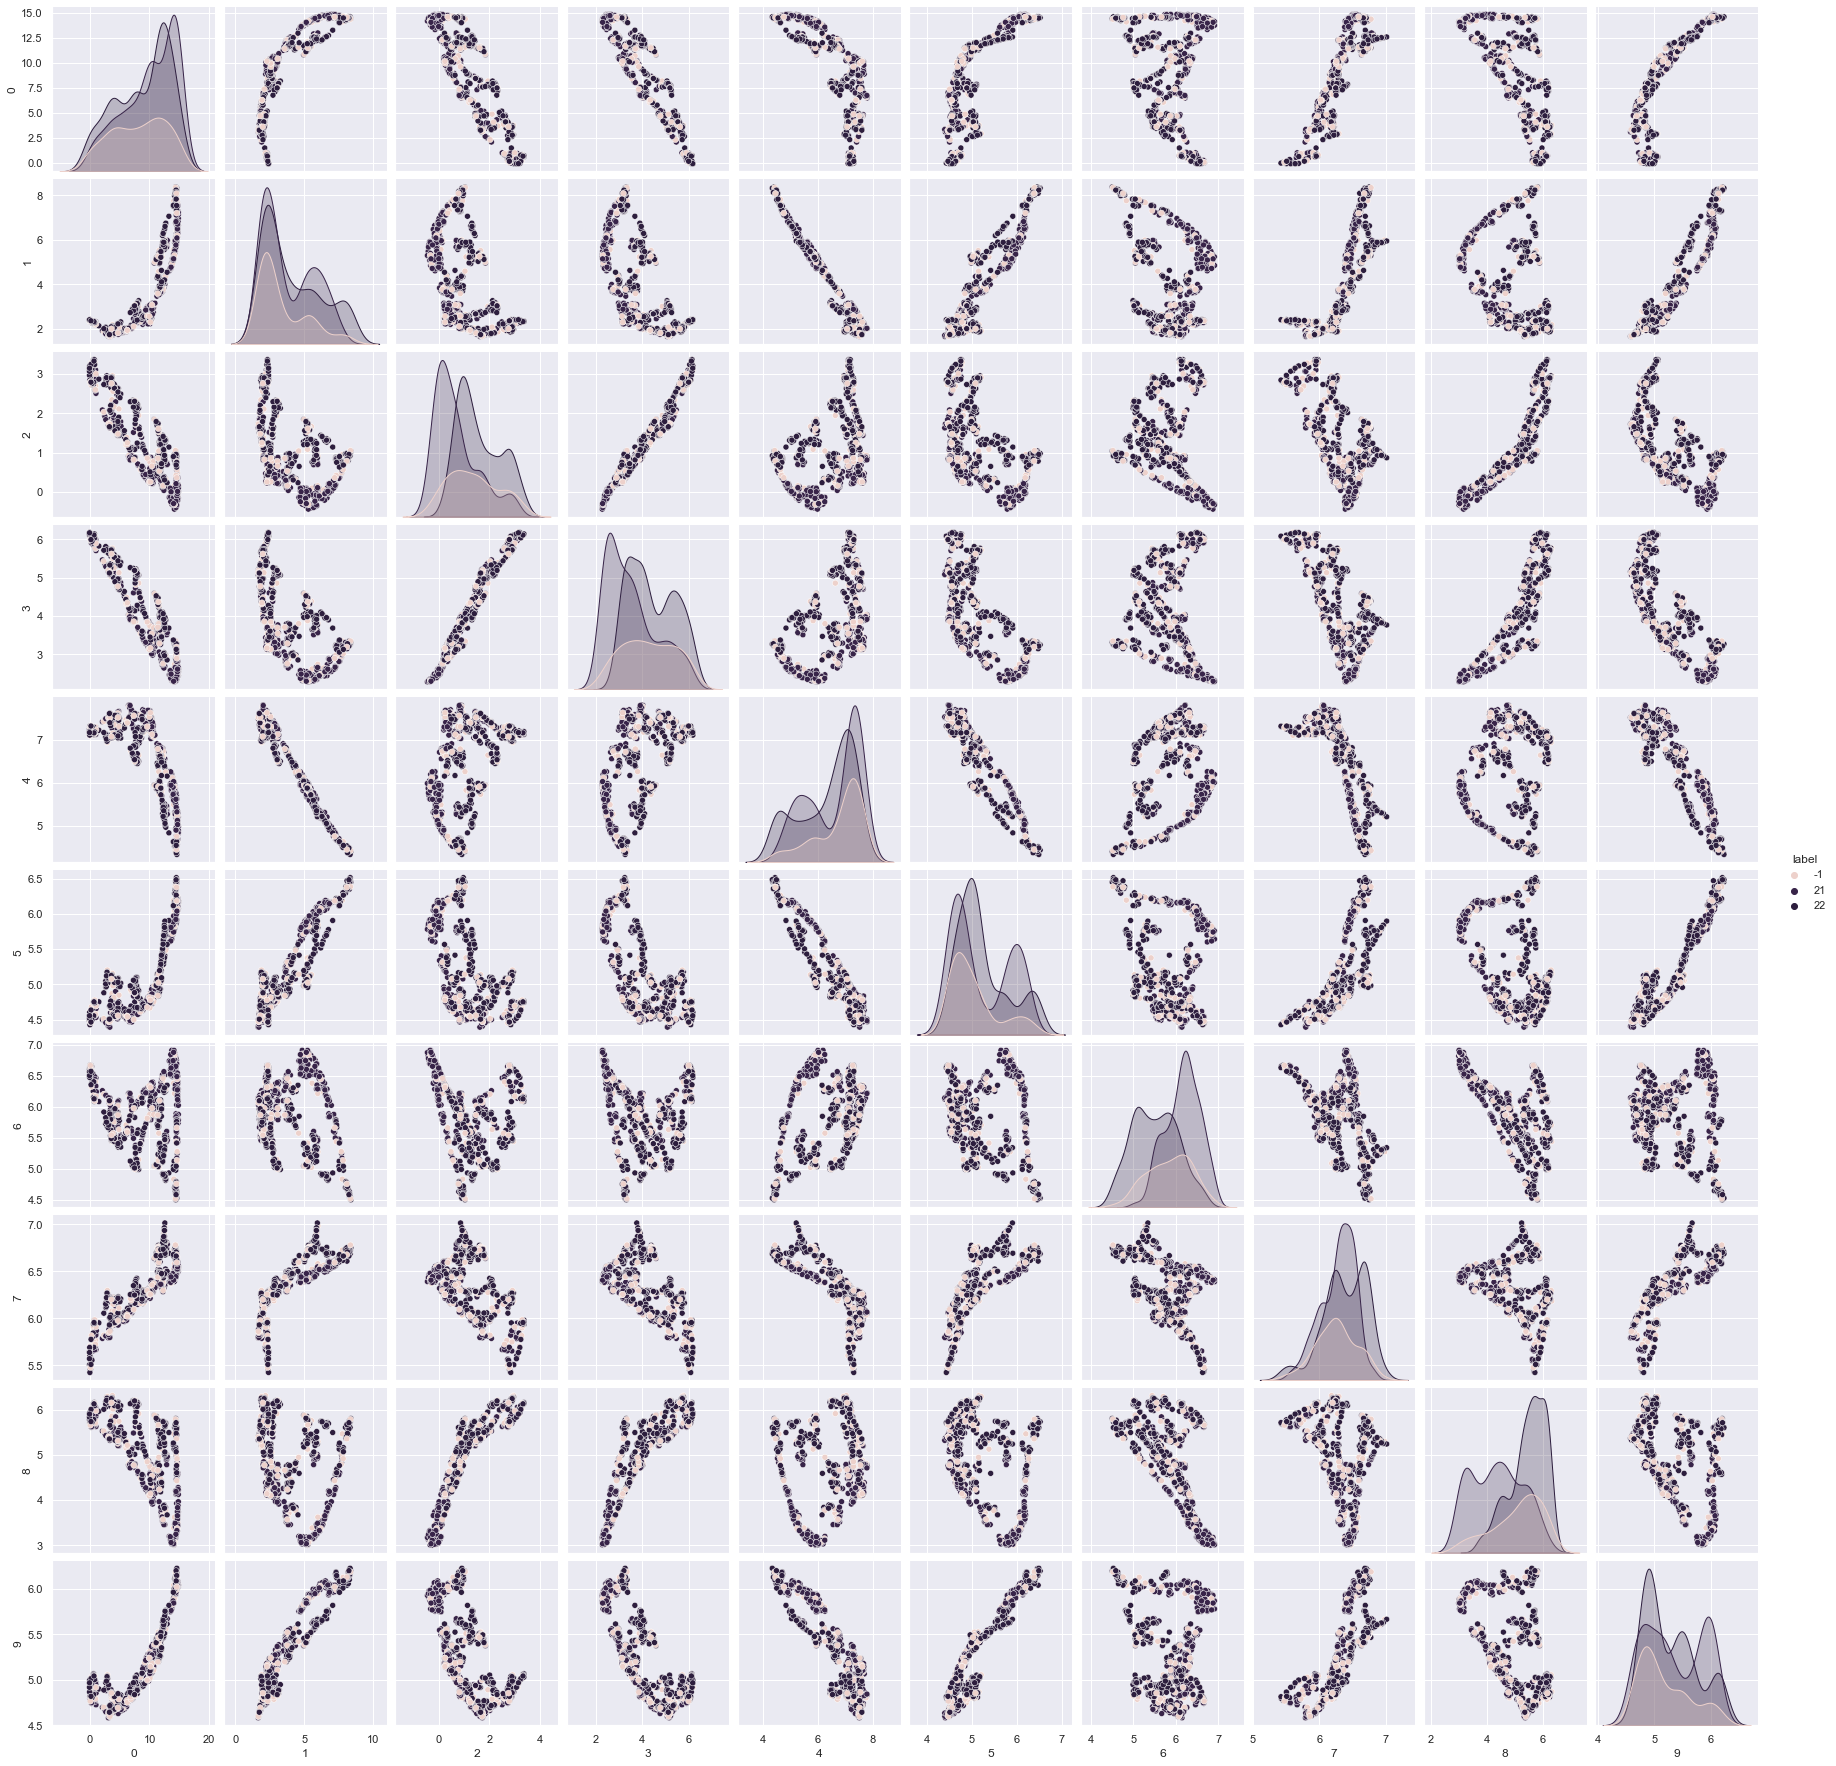

In [52]:
pair = pd.DataFrame(train_umap)
pair['label'] = train_labels
sns.pairplot(pair, hue='label')

In [38]:
tuned_parameters = [
      {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1), 'kernel': ['rbf']}
]
svm = RandomizedSearchCV(SVC(), tuned_parameters)
svm.fit(train_umap, train_labels)

RandomizedSearchCV(estimator=SVC(),
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000297D95C0408>,
                                         'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000297D487E4C8>,
                                         'kernel': ['rbf']}])

In [15]:
param_dic = {"C" : [0.0001, 0.001, 0.1, 0.2, 0.5, 1.0, 2.0, 3.0, 10.0], "gamma" : [0.0001, 0.001, 0.1, 1.0, 2.0, 5.0]}
param_grid = ParameterGrid(param_dic)
svm = GridSearchCV(SVC(kernel="rbf"), param_dic)
svm = svm.fit(train_umap, train_labels)

In [39]:
train_pred = svm.predict(train_umap)
print(classification_report(train_labels, train_pred, target_names=targets.astype(str)))

              precision    recall  f1-score   support

          21       1.00      1.00      1.00       354
          22       1.00      1.00      1.00       354

    accuracy                           1.00       708
   macro avg       1.00      1.00      1.00       708
weighted avg       1.00      1.00      1.00       708



In [45]:
test_pca = pca.transform(test_data)
test_umap = umap.transform(test_pca)
test_pred = svm.predict(test_umap)
print(classification_report(test_labels, test_pred, target_names=targets.astype(str)))

              precision    recall  f1-score   support

          21       0.69      0.85      0.76        52
          22       0.79      0.61      0.69        51

    accuracy                           0.73       103
   macro avg       0.74      0.73      0.72       103
weighted avg       0.74      0.73      0.72       103



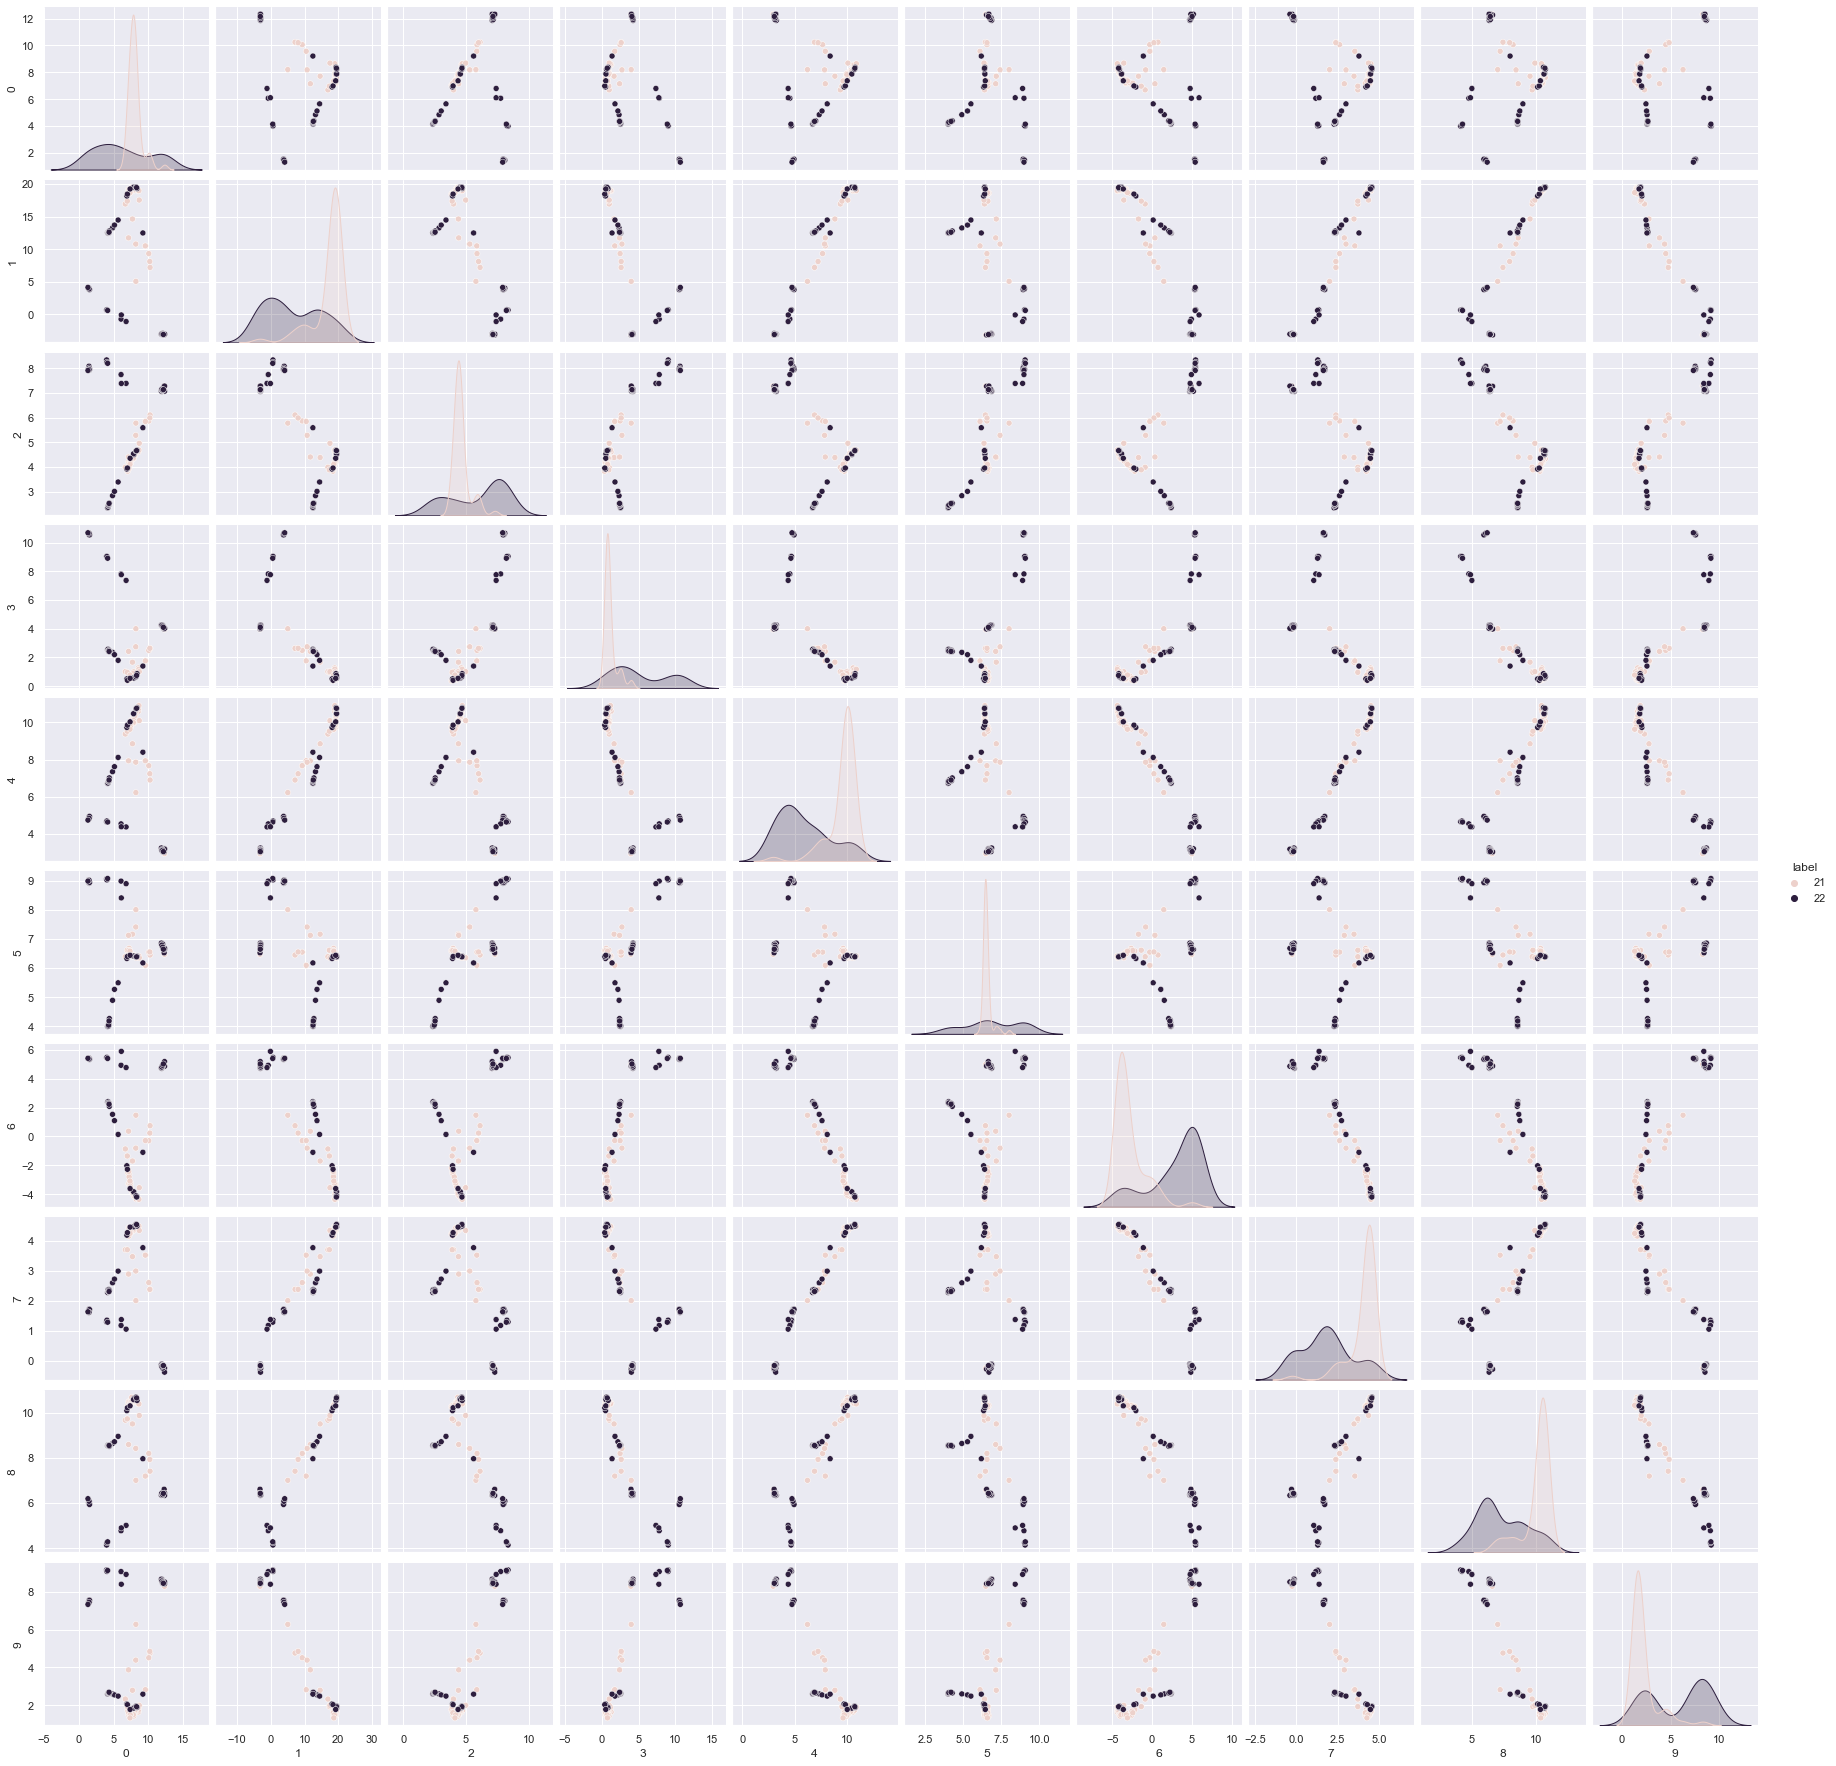

In [46]:
pair = pd.DataFrame(test_umap)
pair['label'] = test_labels
sns.pairplot(pair, hue='label')

In [10]:
def fit_model():
    
    pca = PCA(n_components=100)
    pca = pca.fit(train_data)
    train_pca = pca.transform(train_data)
    tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit(train_pca)
    train_tSNE = tsne.transform(train_pca)

    
def evaluate_model(pca, clust):
    
    val_matrix = tf.math.confusion_matrix(val_labels-factor_labels, val_preds)
    test_matrix = tf.math.confusion_matrix(test_labels-factor_labels, test_preds)
    
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    axlabs = [str(l) for l in np.unique(np.sort(train_labels))]

    im = sns.heatmap(ax=ax[0], data=val_matrix, annot=True, fmt="d")
    ax[0].set_xticks(np.arange(nclasses))
    ax[0].set_yticks(np.arange(nclasses))
    ax[0].set_xticklabels(axlabs)
    ax[0].set_yticklabels(axlabs)
    ax[0].set_title("Validation conf matrix")

    im = sns.heatmap(ax=ax[1], data=test_matrix, annot=True, fmt="d")
    ax[1].set_xticks(np.arange(nclasses))
    ax[1].set_yticks(np.arange(nclasses))
    ax[1].set_xticklabels(axlabs)
    ax[1].set_yticklabels(axlabs)
    ax[1].set_title("Test confusion matrix")

    plt.show()